In [ ]:
# torchvision 是图像处理的包，transforms是其中的一个类
# 神经网络的激活函数再troch.nn.functional 中
# torch中的optim是优化器
from torchvision import transforms
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch import optim
from PIL import Image
import matplotlib.pyplot as plt
from time import sleep

plt.rcParams['font.sans-serif']=['simhei']   #用于正常显示中文标签
plt.rcParams['axes.unicode_minus']=False     #用于正常显示负号

将Mnist数据集加载到内存中,使用分批训练

In [ ]:
train_batch_size=64
test_batch_size=1000
img_size=28

# assert 是设置的检查点，判断是否输入有异常
def get_dataloader(train=True):
    assert isinstance(train,bool)
    # 准备数据集，其中0.1307，0.3081为MNIST数据集的均值和标准差，这样操作能够对其进行标准化
    # 因为MNIST只有一个通道（黑白），所以元组中只有一个值
    dataset=torchvision.datasets.MNIST('/data',train=train,download=True,\
        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),\
        torchvision.transforms.Normalize((0.1307,),(0.3081,)),]))
    # 准备数据迭代器
    batch_size=train_batch_size if train else test_batch_size
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
    return dataloader

In [ ]:
class Evaluator:
    # resultList为传入的分类结果列表，每一行代表不同的类，第0列代表正确分类的个数(TP)，第一列代表被分为该类的样本总数，第二列代表应分为该类的样本数

    def __init__(self)->None:
        self.ClassResult={i:[] for i in range(10)}
        self.MacroAvg=[]
        self.MicroAvg=[]
        return 

    def addTrainResult(self,resultList,sampleSize) -> None:
        TP = [data[0] for data in resultList]  # 初始化TP列表
        FN = [data[2]-data[0] for data in resultList]  # 初始化FN列表
        FP = [data[1]-data[0] for data in resultList]  # 初始化FP列表
        TN = [sampleSize-data[2]+data[0]-data[1] for data in resultList]  # 初始化TN列表
        Accuracy = [(tp+tn)/sampleSize for tp,tn in zip(TP,TN)]  # 初始化正确率
        Precision = [tp/(tp+fp) for tp,fp in zip(TP,FP)]  # 初始化准确率
        Recall = [tp/(tp+fn) for tp,fn in zip(TP,FN)]  # 初始化召回率
        F_score = [2*p*r/(p+r) for p,r in zip(Precision,Recall)]  # 初始化F值
        t=self.getClassResult(Accuracy,Precision,Recall,F_score)
        for i in range(10):
            self.ClassResult[i].append(t[i])
        self.MacroAvg.append(self.getMacroAvg(Accuracy,Precision,Recall,F_score))
        self.MicroAvg.append(self.getMicroAvg(TP,FP,TN,FN,sampleSize))
        
    # 获取小类的识别率
    # 第0列为正确率 第1列为准确率 第2列为召回率 第3列为F值
    def getClassResult(self,Accuracy,Precision,Recall,F_score):
        return [[a,f,r,p] for a,f,r,p in zip(Accuracy,Precision,Recall,F_score)]

    # 获取宏平均 先计算各个小类的指标，再计算平均值
    # 列表的0 1 2 3分别为正确率、准确率、召回率、F值
    def getMacroAvg(self,Accuracy,Precision,Recall,F_score):
        averageAccuracy = sum(Accuracy)/len(Accuracy)
        averagePrecision = sum(Precision)/len(Precision)
        averageRecall = sum(Recall)/len(Recall)
        averageF_score = sum(F_score)/len(F_score)
        return [averageAccuracy,averagePrecision,averageRecall,averageF_score]
    
    # 获取微平均 先计算TP, FP, TN, FN的平均值，再计算指标
    # 列表的0 1 2 3分别为正确率、准确率、召回率、F值
    def getMicroAvg(self,TP,FP,TN,FN,sampleSize):
        averageTP = sum(TP)/len(TP)
        averageFP = sum(FP)/len(FP)
        averageTN = sum(TN)/len(TN)
        averageFN = sum(FN)/len(FN)
        averageAccuracy = (averageTP+averageTN)/sampleSize
        averagePrecision = averageTP/(averageTP+averageFP)
        averageRecall = averageTP/(averageTP+averageFN)
        averageF_score = 2*averagePrecision*averageRecall/(averagePrecision+averageRecall)
        return [averageAccuracy,averagePrecision,averageRecall,averageF_score]

    def plotVisual(self,col0,col1,col2,col3,title)->None:
        times=len(col0)
        x=[i for i in range(1,times+1)]
        fig,ax=plt.subplots()
        ax.set_xlabel('训练的次数')
        ax.set_xticks(range(1,times+1))
        ax.plot(x,col0,label='正确率')
        ax.plot(x,col1,label='准确率')
        ax.plot(x,col2,label='召回率')
        ax.plot(x,col3,label='F值')
        ax.set_title(title)
        ax.legend(); 
        return 

    def visual(self)->None:
        # 宏平均可视化
        self.plotVisual([i[0] for i in self.MacroAvg],[i[1] for i in self.MacroAvg],\
            [i[2] for i in self.MacroAvg],[i[3] for i in self.MacroAvg],'宏平均可视化')

        # 微平均可视化
        self.plotVisual([i[0] for i in self.MicroAvg],[i[1] for i in self.MicroAvg],\
            [i[2] for i in self.MicroAvg],[i[3] for i in self.MicroAvg],'微平均可视化')

        # 小类可视化
        for num in range(10):
            self.plotVisual([i[0] for i in self.ClassResult[num]],[i[1] for i in self.ClassResult[num]],\
            [i[2] for i in self.ClassResult[num]],[i[3] for i in self.ClassResult[num]],'{}的可视化'.format(num))

        return

搭建全连接神经网络  

输入数据的形状:[batch_size,28*28]

输出的神经元是10个

使用反向传播算法进行优化

<p>训练的流程：<br>
    1、实例化的模型，设置模型为训练模式<br>
    2、实例化优化器类，实例化损失函数<br>
    3、获取，遍历dataloader<br>
    4、梯度置为0<br>
    5、进行向前计算<br>
    6、计算损失<br>
    7、反向传播<br>
    8、更新参数</p>

In [ ]:
class MnistNet(torch.nn.Module):
    def __init__(self):
        super(MnistNet,self).__init__()
        self.fc1=torch.nn.Linear(28*28,28)
        self.fc2=torch.nn.Linear(28,10)
        self.evalue=Evaluator()
    
    def forward(self,x):
        x=x.view(-1,28*28)
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc2(x)
        # out=F.log_softmax(x,dim=-1)
        return F.log_softmax(x,dim=-1)

In [ ]:
mnist_net=MnistNet() # 实例化模型
optimizer=torch.optim.Adam(mnist_net.parameters(),lr=0.001) # 优化器
train_loss_list=[]
train_count_list=[]

# epoch表示训练的次数
def train(epoch):
    print("第{}次训练开始. . . .".format(epoch))
    mnist_net.train(True)
    train_dataloader=get_dataloader(True)# 获取训练数据
    cnt=[[0]*3 for i in range(10)]
    datasize=0
    rightcnt=0
    for index,(data,target) in enumerate(train_dataloader):
        optimizer.zero_grad()# 将梯度进行置0
        output=mnist_net.forward(data)

        # 统计预测的结果
        pred=output.data.max(1,keepdim=True)[1]
        datasize+=len(target)
        for i in range(len(target)):
            # 第0列是正确分类为该数字的个数  cnt0
            # 1列是分类为改数字的总个数      cnt1
            # 2列是应该分类为改数字的个数    cnt2
            cnt[int(pred[i][0])][1]+=1
            cnt[int(target[i])][2]+=1
            if pred[i][0]==target[i]:
                cnt[int(pred[i][0])][0]+=1
                rightcnt+=1

        loss=F.nll_loss(output,target)
        loss.backward()
        optimizer.step()
    
    mnist_net.evalue.addTrainResult(cnt,datasize)
    print("-----------------------第{}次训练结束, 正确率是 {}  ".format(epoch,round(rightcnt/datasize,4)))
    print(rightcnt,datasize)
    sleep(0.5)

In [ ]:
epoch=20
for i in range(epoch):
    train(i+1)
mnist_net.evalue.visual()

评估结果

<p>评估和训练很相似，但是不需要计算梯度，需要收集损失和准确率，计算平均损失和平均准确率，损失的计算和训练的损失计算方法相同</p>

In [85]:
def plotVisual2(y:list,title:str)->None:
    fig,ax=plt.subplots()
    ax.set_xticks(range(0,10))
    ax.set_title(title)
    ax.set_ylim(0.85,1.00)
    ax.bar([i for i in range(10)],y)
    return 

def test():
    test_loss=0
    correct=0
    mnist_net.eval()
    test_dataloader=get_dataloader(train=False)
    
    result=Evaluator()
    cnt=[[0]*3 for i in range(10)]
    datasize=0

    with torch.no_grad():
        for data,target in test_dataloader:
            output=mnist_net(data)
            test_loss+=F.nll_loss(output,target,reduction='sum').item()
            pred=output.data.max(1,keepdim=True)[1]

            # 统计结果
            datasize+=len(target)
            for i in range(len(target)):
                # 第0列是正确分类为该数字的个数  cnt0
                # 1列是分类为改数字的总个数      cnt1
                # 2列是应该分类为改数字的个数    cnt2
                cnt[int(pred[i][0])][1]+=1
                cnt[int(target[i])][2]+=1
                if pred[i][0]==target[i]:
                    cnt[int(pred[i][0])][0]+=1
            
            correct+=pred.eq(target.data.view_as(pred)).sum()
    test_loss/=len(test_dataloader.dataset)
    print('\n损失函数总和: {:.4f}, 正确率: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    # 打印测试结果
    result.addTrainResult(cnt,datasize)
    macro=result.MacroAvg[0]
    micro=result.MicroAvg[0]
    # 宏平均
    print('宏平均:\n')
    print('--------正确率:{}\n'.format(macro[0]))
    print('--------准确率:{}\n'.format(macro[1]))
    print('--------召回率:{}\n'.format(macro[2]))
    print('-------- F值  :{}\n'.format(macro[3]))

    # 微平均
    print('微平均:\n')
    print('--------正确率:{}\n'.format(micro[0]))
    print('--------准确率:{}\n'.format(micro[1]))
    print('--------召回率:{}\n'.format(micro[2]))
    print('-------- F值  :{}\n'.format(micro[3]))
    
    cols=[[result.ClassResult[i][0][0] for i in range(0,10)],
        [result.ClassResult[i][0][1] for i in range(0,10)],
        [result.ClassResult[i][0][2] for i in range(0,10)],
        [result.ClassResult[i][0][3] for i in range(0,10)]]
    titles=['正确率','准确率','召回率','F值']
    for y,title in zip(cols,titles):
        plotVisual2(y,title)
    
    return 


损失函数总和: 0.2093, 正确率: 9375/10000 (93.75%)

宏平均:

--------正确率:0.9875

--------准确率:0.9375797044005235

--------召回率:0.9364665421690803

-------- F值  :0.9366686757833407

微平均:

--------正确率:0.9875

--------准确率:0.9375

--------召回率:0.9375

-------- F值  :0.9375



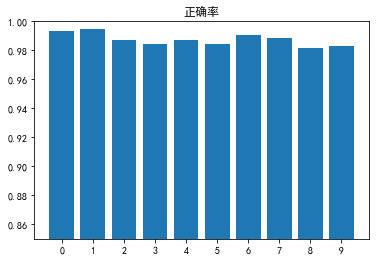

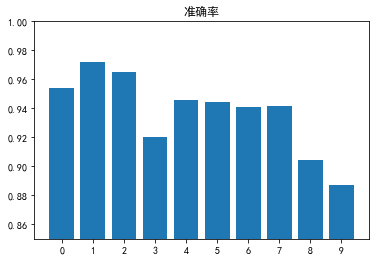

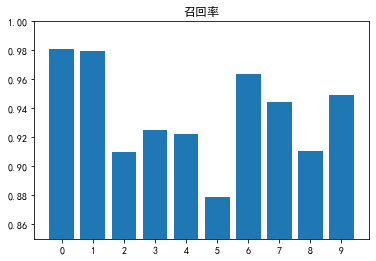

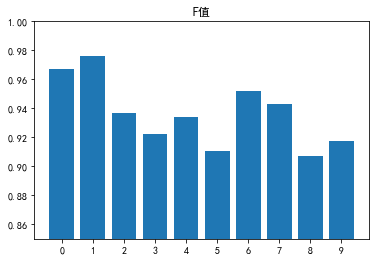

In [86]:
test()